# Let's create a chlorophyll data set to be used for ML

In [3]:
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt

import xesmf

In [4]:
ds = xr.open_dataset('/data/artemis/workspace/vbennington/GlobColour/originals/L3m_GLOB_CHL1_199801-202012.nc')

In [5]:
chl_tmp = ds.CHL1_mean
clat = chl_tmp.lat
clon = chl_tmp.lon

In [9]:
date_range_start = '1998-01-01T00:00:00.000000000'
date_range_end = '2020-12-31T00:00:00.000000000'

# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

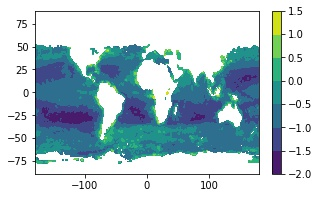

In [6]:
fig = plt.figure(figsize=(5,3))
plt.contourf(clon,clat,np.ma.log10(chl_tmp[12,:,:]))
plt.colorbar()

# First let's create a climatology of what we've got

In [10]:
df_chl = xr.Dataset({'chl':(["time","lat","lon"],chl_tmp)
                    },
                        coords={'time': (['time'],dates),
                        'ylat': (['ylat'],clat),
                        'xlon':(['xlon'],clon)})

In [11]:
cyc_chl = df_chl['chl'].groupby("time.month").mean("time")

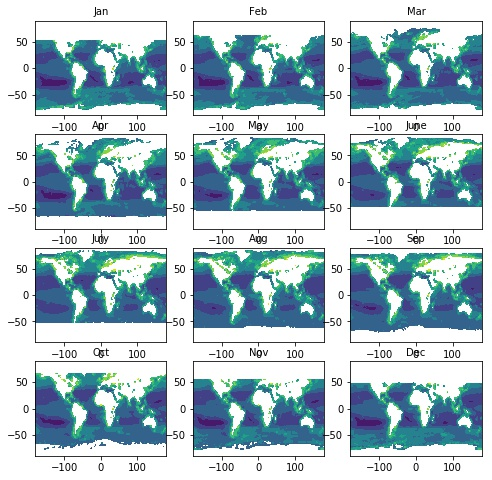

In [20]:
months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
fig, axs = plt.subplots(4,3,figsize=(8,8))
for mo in range(0,12):
    r = mo // 3
    c = mo % 3
    axs[r,c].contourf(clon,clat,np.ma.log10(cyc_chl[mo,:,:]))
    axs[r,c].set_title(f'{months[mo]}',fontsize=10)

# Missing poles in winter.
 Gregor et al. (2019) fills with random noise
 
 Luke Gloege fills with climatology from months we can see

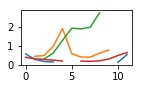

In [13]:
# Let's look at one point on the poles to see if this is reasonable:

fig = plt.figure(figsize=(2,1))
plt.plot(range(0,12),cyc_chl[:,150,180])
plt.plot(range(0,12),cyc_chl[:,30,180])
plt.plot(range(0,12),cyc_chl[:,20,210])
plt.plot(range(0,12),cyc_chl[:,140,160])

In [49]:
# Should we linearly interplote between these points?
# Let' create a couple options here. 
# Climatology from months we have, like Luke, and interpolating (linearly) between months we do have

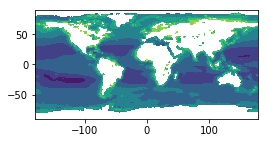

In [15]:
# Let's identify land
tmp = cyc_chl.mean("month")

fig = plt.figure(figsize=(4,2))
plt.contourf(clon,clat,np.ma.log10(tmp))

In [16]:
some_data = ~np.isnan(tmp)
np.shape(some_data)

(180, 360)

In [34]:
# Because Winter at the north pole is at the end/start of the year:
chl_looped = np.empty(shape=(24,180,360))
chl_looped[0:6,:,:] = cyc_chl[6:12,:,:]
chl_looped[6:18,:,:] = cyc_chl
chl_looped[18:24,:,:] = cyc_chl[0:6,:,:]
chl_loop = xr.Dataset({'chl':(['time','lat','lon'],chl_looped)},
                       coords={'time':(['time'],range(0,24)),
                              'lat':(['lat'],cyc_chl.lat.values),
                              'lon':(['lon'],cyc_chl.lon.values)})

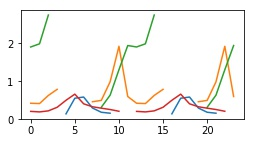

In [18]:
fig = plt.figure(figsize=(4,2))
plt.plot(range(0,24),chl_looped[:,150,180])
plt.plot(range(0,24),chl_looped[:,30,180])
plt.plot(range(0,24),chl_looped[:,20,210])
plt.plot(range(0,24),chl_looped[:,140,160])

In [36]:
# Interpolate point by point the missing months of data (interpolate along the time dimension):

chl_loop_interp = chl_loop.chl.interpolate_na(dim='time',method='linear',limit=7)

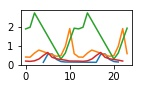

In [37]:
fig = plt.figure(figsize=(2,1))
plt.plot(range(0,24),chl_loop_interp[:,150,180])
plt.plot(range(0,24),chl_loop_interp[:,30,180])
plt.plot(range(0,24),chl_loop_interp[:,20,210])
plt.plot(range(0,24),chl_loop_interp[:,140,160])

In [54]:
chl_interp_clim = chl_loop_interp[6:18,:,:]

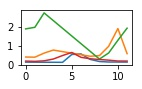

In [58]:
fig = plt.figure(figsize=(2,1))
plt.plot(range(0,12),chl_interp_clim[:,150,180])
plt.plot(range(0,12),chl_interp_clim[:,30,180])
plt.plot(range(0,12),chl_interp_clim[:,20,210])
plt.plot(range(0,12),chl_interp_clim[:,140,160])

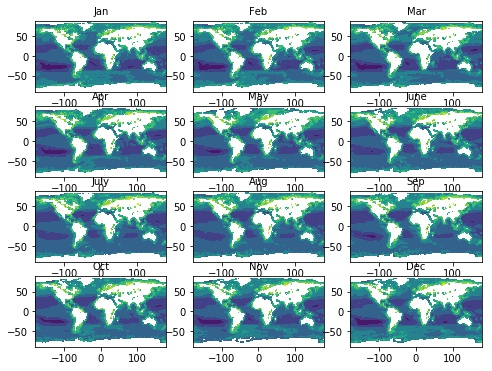

In [39]:
fig, axs = plt.subplots(4,3,figsize=(8,6))
for mo in range(0,12):
    r = mo // 3
    c = mo % 3
    axs[r,c].contourf(clon,clat,np.ma.log10(chl_interp_clim[mo,:,:]))
    axs[r,c].set_title(f'{months[mo]}',fontsize=10)

In [74]:
# Now let's get a time series for 198201 - 201912

# 1982 - 1997 is just climatology of chlorophyll values  (missing months interpolated point by point) (Technique 1)
# 1998 - 2019 includes year to year variability (interpolating between missing months) (Technique 1)

# 1982 - 1997 is just climatology of CHL values for months we have (missing months filled with local mean for months we have) (Technique 2)
# 1998 - 2019 includes year to year variability (missing values filled with climatology of that point) (Technique 2)


# Technique 1 -- Interpolate between months of data

In [40]:
chl_interp_tmp = np.empty(shape=(468,180,360))

In [41]:
# Put Climatological Cycle in for 1982-1997:

for y in range(1982,1998):
    chl_interp_tmp[(y-1982)*12:(y-1981)*12,:,:] = chl_interp_clim

In [42]:
chl_interp_tmp[16*12:468,:,:] = chl_tmp

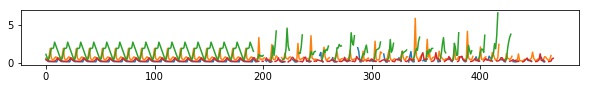

In [43]:
# Spot Check:

fig = plt.figure(figsize=(10,1))
plt.plot(range(0,468),chl_interp_tmp[:,150,180])
plt.plot(range(0,468),chl_interp_tmp[:,30,180])
plt.plot(range(0,468),chl_interp_tmp[:,20,210])
plt.plot(range(0,468),chl_interp_tmp[:,140,160])

In [46]:
# Interpolate point by point the missing months of data (interpolate along the time dimension):

# Need Dataset:
tmp = xr.Dataset({'chl':(['time','lat','lon'],chl_interp_tmp)},
                       coords={'time':(['time'],range(0,468)),
                              'lat':(['lat'],cyc_chl.lat.values),
                              'lon':(['lon'],cyc_chl.lon.values)})

chl_interp_interm = tmp.chl.interpolate_na(dim='time',method='linear',limit=7)

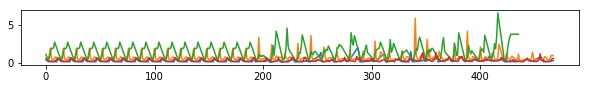

In [47]:
# Spot Check:
# Probably still missing values we will need to fill with CLIMATOLOGY

fig = plt.figure(figsize=(10,1))
plt.plot(range(0,468),chl_interp_interm[:,150,180])
plt.plot(range(0,468),chl_interp_interm[:,30,180])
plt.plot(range(0,468),chl_interp_interm[:,20,210])
plt.plot(range(0,468),chl_interp_interm[:,140,160])

In [57]:
# Repeat climatology:

print(np.shape((chl_interp_clim)))

(12, 180, 360)


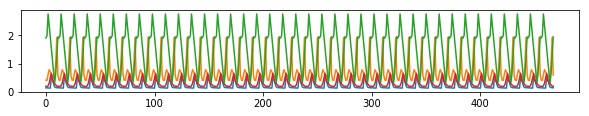

In [62]:
# Find any missing months and fill with Climatology for that specific month:
# Need Datasets:
tmp = xr.Dataset({'chl':(['time','lat','lon'],chl_interp_interm),
                 'clim_repeat':(['time','lat','lon'],np.tile(chl_interp_clim,(39,1,1)))},
                       coords={'time':(['time'],range(0,468)),
                              'lat':(['lat'],cyc_chl.lat.values),
                              'lon':(['lon'],cyc_chl.lon.values)})

fig = plt.figure(figsize=(10,1.5))
plt.plot(range(0,468),tmp.clim_repeat[:,150,180])
plt.plot(range(0,468),tmp.clim_repeat[:,30,180])
plt.plot(range(0,468),tmp.clim_repeat[:,20,210])
plt.plot(range(0,468),tmp.clim_repeat[:,140,160])
                                            

In [63]:
chl_interp_final = tmp.chl.fillna(tmp.clim_repeat)

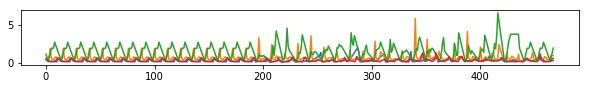

In [64]:
# Spot Check:
# Probably still missing values we will need to fill with CLIMATOLOGY

fig = plt.figure(figsize=(10,1))
plt.plot(range(0,468),chl_interp_final[:,150,180])
plt.plot(range(0,468),chl_interp_final[:,30,180])
plt.plot(range(0,468),chl_interp_final[:,20,210])
plt.plot(range(0,468),chl_interp_final[:,140,160])

In [67]:
date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2020-12-31T00:00:00.000000000'

# create date vector
dates2 = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

In [68]:
# Interpolate onto SOCAT GRID #####
###################################
socat = xr.open_dataset('/data/artemis/observations/SOCAT/originals/SOCATv2020_tracks_gridded_monthly.nc')
fco2_weighted = socat.fco2_ave_weighted
time = fco2_weighted.tmnth
ylat = fco2_weighted.ylat
xlon = fco2_weighted.xlon

cgrid = xr.Dataset({'lat':(['lat'],clat.values),'lon':(['lon'],clon.values)})
sgrid = xr.Dataset({'lat':(['lat'],ylat.values),'lon':(['lon'],xlon.values)})
chl_in = xr.Dataset({'chl':(['time','lat','lon'],chl_interp_final),'time':(['time'],dates2.values),'lat':(['lat'],clat.values),'lon':(['lon'],clon.values)})

In [69]:
# Now let's grab 1982 - 2019 and write to file:
regridder = xesmf.Regridder(chl_in, sgrid, 'bilinear')

Overwrite existing file: bilinear_180x360_180x360.nc 
 You can set reuse_weights=True to save computing time.


In [70]:
chl_out = regridder(chl_in.chl)

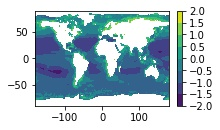

In [71]:
fig = plt.figure(figsize=(3,1.75))
plt.contourf(xlon,ylat,np.ma.log10(chl_out[80,:,:]))
plt.colorbar()

In [76]:
chl_interp_out = xr.Dataset({
                        'chl':(["time","ylat","xlon"],chl_out)},
                        coords={'time': (['time'],dates2),
                        'ylat': (['ylat'],ylat),
                        'xlon':(['xlon'],xlon)})
        
# Save to netcdf

chl_interp_out['chl'].attrs['description'] = "Interpolated linearly between months, climatology prior to 1998"
chl_interp_out['chl'].attrs['units'] = "mg / m3"
chl_interp_out.to_netcdf('/data/artemis/workspace/vbennington/GlobColour/processed/CHL_interpFILL_mon_198201-202012.nc') 

## Technique 2 (Fill missing months of climatology with mean from rest of year)

In [ ]:
# Clear Variables from above 
del chl_interp_out, chl_out, chl_in, tmp, chl_interp_tmp, chl_loop_interp, chl_loop, chl_looped, chl_interp_clim, chl_interp_final, chl_interp_interm  

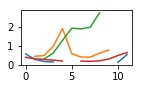

In [77]:
# Let's look at one point on the poles to see if this is reasonable:

fig = plt.figure(figsize=(2,1))
plt.plot(range(0,12),cyc_chl[:,150,180])
plt.plot(range(0,12),cyc_chl[:,30,180])
plt.plot(range(0,12),cyc_chl[:,20,210])
plt.plot(range(0,12),cyc_chl[:,140,160])

In [78]:
# Fill in missing months of climatology with mean of months we do have:

cyc_chl_fill = cyc_chl.fillna(np.tile(cyc_chl.mean(axis=0),(12,1,1)))

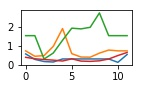

In [79]:
# Let's look at one point on the poles to see if this is reasonable:

fig = plt.figure(figsize=(2,1))
plt.plot(range(0,12),cyc_chl_fill[:,150,180])
plt.plot(range(0,12),cyc_chl_fill[:,30,180])
plt.plot(range(0,12),cyc_chl_fill[:,20,210])
plt.plot(range(0,12),cyc_chl_fill[:,140,160])

In [151]:
# Now have all the values we can come up with for 1982-1997
# Need to fill the missing locations/months with climatology for that month

In [80]:
chl_fill_tmp = np.empty(shape=(468,180,360))

In [81]:
for year in range(1982,1998):
    chl_fill_tmp[(year-1982)*12:(year-1981)*12,:,:]=cyc_chl_fill

In [82]:
chl_fill_tmp[12*16:468,:,:]=chl_tmp

In [ ]:
tmp = xr.Dataset({'chl':(['time','lat','lon'],chl_fill_tmp),
                 'clim_repeat':(['time','lat','lon'],np.tile(cyc_chl_fill,(39,1,1)))},
                       coords={'time':(['time'],range(0,468)),
                              'lat':(['lat'],cyc_chl.lat.values),
                              'lon':(['lon'],cyc_chl.lon.values)})

In [84]:
chl_fill_final=tmp.chl.fillna(tmp.clim_repeat)

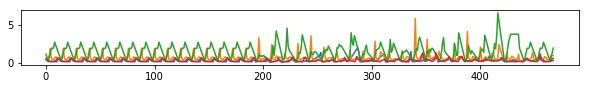

In [85]:
fig = plt.figure(figsize=(10,1))
plt.plot(range(0,468),chl_fill_final[:,150,180])
plt.plot(range(0,468),chl_fill_final[:,30,180])
plt.plot(range(0,468),chl_fill_final[:,20,210])
plt.plot(range(0,468),chl_fill_final[:,140,160])

In [160]:
chl_in = xr.Dataset({'chl':(['time','lat','lon'],chl_fill_final),'time':(['time'],dates.values),'lat':(['lat'],clat.values),'lon':(['lon'],clon.values)})

In [161]:
# Regrid

regridder = xesmf.Regridder(chl_in, sgrid, 'bilinear')

Overwrite existing file: bilinear_180x360_180x360.nc 
 You can set reuse_weights=True to save computing time.


In [162]:
chl_out = regridder(chl_in.chl)

In [163]:
chl_fill_out = xr.Dataset({
                        'chl':(["time","ylat","xlon"],chl_out)},
                        coords={'time': (['time'],dates),
                        'ylat': (['ylat'],ylat),
                        'xlon':(['xlon'],xlon)})
chl_fill_out['chl'].attrs['description'] = "Missing months get climatological mean, climatology prior to 1998"
chl_fill_out['chl'].attrs['units'] = "mg / m3"
    # Save to netcdf
chl_fill_out.to_netcdf('/data/artemis/workspace/vbennington/GlobColour/processed/CHL_climFILL_mon_198201-202012.nc') 

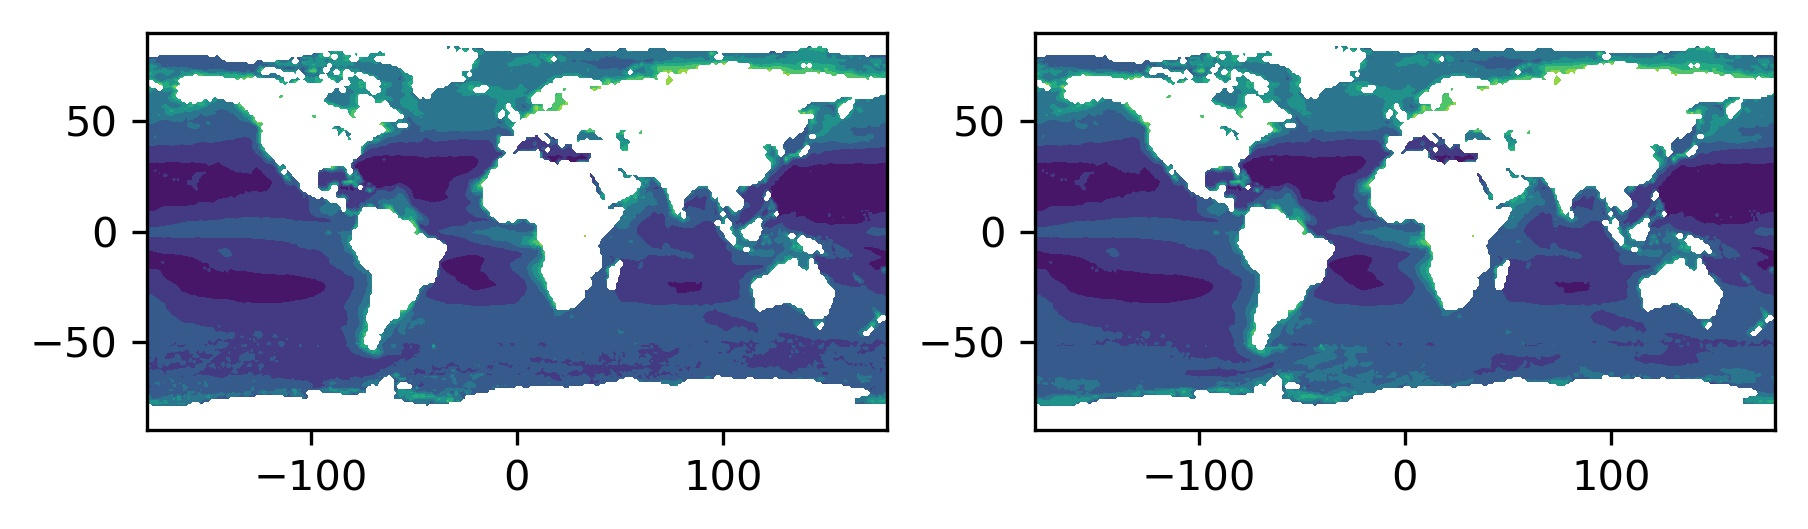

In [174]:
fig,axs = plt.subplots(1,2,figsize=(7,1.75))
axs[1].contourf(xlon,ylat,np.ma.log10(chl_fill_out.chl[78,:,:]))
axs[0].contourf(xlon,ylat,np.ma.log10(chl_interp_out.chl[78,:,:]))